# U^2-Net 및 OpenVINO™를 사용한 이미지 배경 제거

이 노트북은 U$^2$-Net 및 OpenVINO를 사용하여 이미지에서 배경 제거를 보여줍니다.

소스 코드 및 테스트 데이터를 포함하여 U$^2$-Net에 대한 자세한 내용은 [GitHub 페이지](https://github.com/xuebinqin/U-2-Net) 및 연구 논문: [U^ 2-Net: 핵심 개체 감지를 위한 중첩된 U 구조를 통한 심층 분석](https://arxiv.org/pdf/2005.09007.pdf).

PyTorch U$^2$-Net 모델은 OpenVINO IR 형식으로 변환됩니다. 모델 소스는 [여기](https://github.com/xuebinqin/U-2-Net)에서 확인할 수 있습니다.

#### 내용의 테이블:
- [준비](#준비-위화살표)
     - [설치 요구 사항](#Install-requirements-Uparrow)
     - [PyTorch 라이브러리 및 U$^2$-Net 가져오기](#Import-the-PyTorch-Library-and-U2-Net-Uparrow)
     - [설정](#설정-위쪽 화살표)
     - [U$^2$-Net 모델 로드](#Load-the-U2-Net-Model-Uparrow)
- [PyTorch U$^2$-Net 모델을 OpenVINO IR로 변환](#Convert-PyTorch-U2-Net-model-to-OpenVINO-IR-Uparrow)
     - [Pytorch 모델을 OpenVINO IR 형식으로 변환](#Convert-Pytorch-model-to-OpenVINO-IR-Format-Uparrow)
- [입력 이미지 로드 및 전처리](#Load-and-Pre-Process-Input-Image-Uparrow)
- [추론 장치 선택](#Select-inference-device-Uparrow)
- [OpenVINO IR 모델에서 추론 수행](#Do-Inference-on-OpenVINO-IR-Model-Uparrow)
- [결과 시각화](#Visualize-Results-Uparrow)
     - [배경 이미지 추가](#Add-a-Background-Image-Uparrow)
- [참고자료](#References-Uparrow)

## 준비 [$\Uparrow$](#목차:)

### 설치 요구 사항 [$\Uparrow$](#목차:)


In [1]:
%pip install -q "openvino>=2023.1.0"
%pip install -q torch opencv-python matplotlib
%pip install -q gdown

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 85.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 68.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 74.6 MB/s eta 0:00:00


### PyTorch 라이브러리 및 U$^2$-Net [$\Uparrow$](#목차:) 가져오기


In [2]:
import os
import time
import sys
from collections import namedtuple
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import openvino as ov
import torch
from IPython.display import HTML, FileLink, display

In [5]:
# Import local modules

utils_file_path = Path("../utils/notebook_utils.py")
notebook_directory_path = Path(".")

if not utils_file_path.exists():
    !git clone --depth 1 https://github.com/openvinotoolkit/openvino_notebooks.git
    utils_file_path = Path("/content/openvino_notebooks/utils/notebook_utils.py")
    notebook_directory_path = Path("/content/openvino_notebooks/notebooks/vision-background-removal")

sys.path.append(str(utils_file_path.parent))
sys.path.append(str(notebook_directory_path))

from notebook_utils import load_image
from model.u2net import U2NET, U2NETP

fatal: destination path 'openvino_notebooks' already exists and is not an empty directory.


### 설정 [$\Uparrow$](#목차:)

이 튜토리얼에서는 원래의 U$^2$-Net 핵심 개체 감지 모델과 더 작은 U2NETP 버전의 사용을 지원합니다. 원래 모델에는 주요 객체 감지와 인간 분할이라는 두 가지 가중치 세트가 지원됩니다.

In [6]:
model_config = namedtuple("ModelConfig", ["name", "url", "model", "model_args"])

u2net_lite = model_config(
    name="u2net_lite",
    url="https://drive.google.com/uc?id=1rbSTGKAE-MTxBYHd-51l2hMOQPT_7EPy",
    model=U2NETP,
    model_args=(),
)
u2net = model_config(
    name="u2net",
    url="https://drive.google.com/uc?id=1ao1ovG1Qtx4b7EoskHXmi2E9rp5CHLcZ",
    model=U2NET,
    model_args=(3, 1),
)
u2net_human_seg = model_config(
    name="u2net_human_seg",
    url="https://drive.google.com/uc?id=1-Yg0cxgrNhHP-016FPdp902BR-kSsA4P",
    model=U2NET,
    model_args=(3, 1),
)

# Set u2net_model to one of the three configurations listed above.
u2net_model = u2net_lite

In [7]:
# The filenames of the downloaded and converted models.
MODEL_DIR = "model"
model_path = Path(MODEL_DIR) / u2net_model.name / Path(u2net_model.name).with_suffix(".pth")

### U$^2$-Net 모델 로드 [$\Uparrow$](#목차:)

U$^2$-Net 인간 분할 모델 가중치는 Google 드라이브에 저장됩니다. 아직 존재하지 않으면 다운로드됩니다. 다음 셀은 모델과 사전 훈련된 가중치를 로드합니다.

In [8]:
if not model_path.exists():
    import gdown

    os.makedirs(name=model_path.parent, exist_ok=True)
    print("Start downloading model weights file... ")
    with open(model_path, "wb") as model_file:
        gdown.download(url=u2net_model.url, output=model_file)
        print(f"Model weights have been downloaded to {model_path}")

Start downloading model weights file... 


Downloading...
From: https://drive.google.com/uc?id=1rbSTGKAE-MTxBYHd-51l2hMOQPT_7EPy
To: <_io.BufferedWriter name='model/u2net_lite/u2net_lite.pth'>
100%|██████████| 4.68M/4.68M [00:00<00:00, 29.8MB/s]

Model weights have been downloaded to model/u2net_lite/u2net_lite.pth


In [9]:
# Load the model.
net = u2net_model.model(*u2net_model.model_args)
net.eval()

# Load the weights.
print(f"Loading model weights from: '{model_path}'")
net.load_state_dict(state_dict=torch.load(model_path, map_location="cpu"))

Loading model weights from: 'model/u2net_lite/u2net_lite.pth'


<All keys matched successfully>

## PyTorch U$^2$-Net 모델을 OpenVINO IR로 변환 [$\Uparrow$](#목차:)


모델 변환 Python API를 사용하여 Pytorch 모델을 OpenVINO IR 형식으로 변환합니다.
다음 명령을 실행하는 데 시간이 걸릴 수 있습니다.

In [10]:
model_ir = ov.convert_model(net, example_input=torch.zeros((1,3,512,512)), input=([1, 3, 512, 512]))

/content/openvino_notebooks/notebooks/vision-background-removal/model/u2net.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')


## 입력 이미지 로드 및 전처리 [$\Uparrow$](#목차:)

OpenCV는 'BGR' 형식의 이미지를 읽는 반면, OpenVINO IR 모델은 'RGB'의 이미지를 기대합니다. 따라서 이미지를 'RGB'로 변환하고 '512 x 512'로 크기를 조정한 다음 OpenVINO IR 모델이 예상하는 형식으로 크기를 바꿉니다.

이미지 텐서에 평균값을 추가하고 표준편차로 입력의 크기를 조정합니다. 이를 네트워크를 통해 전파하기 전에 입력 데이터 정규화라고 합니다. 평균 및 표준 편차 값은 [U^2-Net 저장소]의 [dataloader](https://github.com/xuebinqin/U-2-Net/blob/master/data_loader.py) 파일에서 확인할 수 있습니다. (https://github.com/xuebinqin/U-2-Net/) 0-255의 픽셀 값을 가진 이미지를 지원하기 위해 255를 곱합니다.

In [12]:
IMAGE_URI = "https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/image/coco_hollywood.jpg"

input_mean = np.array([123.675, 116.28 , 103.53]).reshape(1, 3, 1, 1)
input_scale = np.array([58.395, 57.12 , 57.375]).reshape(1, 3, 1, 1)

image = cv2.cvtColor(
    src=load_image("coco_hollywood.jpg",IMAGE_URI),
    code=cv2.COLOR_BGR2RGB,
)

resized_image = cv2.resize(src=image, dsize=(512, 512))
# Convert the image shape to a shape and a data type expected by the network
# for OpenVINO IR model: (1, 3, 512, 512).
input_image = np.expand_dims(np.transpose(resized_image, (2, 0, 1)), 0)

input_image = (input_image - input_mean) / input_scale

## 추론 장치 선택 [$\Uparrow$](#목차:)

OpenVINO를 사용하여 추론을 실행하려면 드롭다운 목록에서 장치를 선택하세요.

In [13]:
import ipywidgets as widgets

core = ov.Core()
device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value='AUTO',
    description='Device:',
    disabled=False,
)

device

Dropdown(description='Device:', index=1, options=('CPU', 'AUTO'), value='AUTO')

## OpenVINO IR 모델에 대한 추론 수행 [$\Uparrow$](#목차:)

OpenVINO IR 모델을 OpenVINO Runtime에 로드하고 추론을 수행합니다.

In [14]:
core = ov.Core()
# Load the network to OpenVINO Runtime.
compiled_model_ir = core.compile_model(model=model_ir, device_name=device.value)
# Get the names of input and output layers.
input_layer_ir = compiled_model_ir.input(0)
output_layer_ir = compiled_model_ir.output(0)

# Do inference on the input image.
start_time = time.perf_counter()
result = compiled_model_ir([input_image])[output_layer_ir]
end_time = time.perf_counter()
print(
    f"Inference finished. Inference time: {end_time-start_time:.3f} seconds, "
    f"FPS: {1/(end_time-start_time):.2f}."
)

Inference finished. Inference time: 2.902 seconds, FPS: 0.34.


## 결과 시각화 [$\Uparrow$](#목차:)

원본 영상, 분할 결과, 배경이 제거된 원본 영상을 표시합니다.

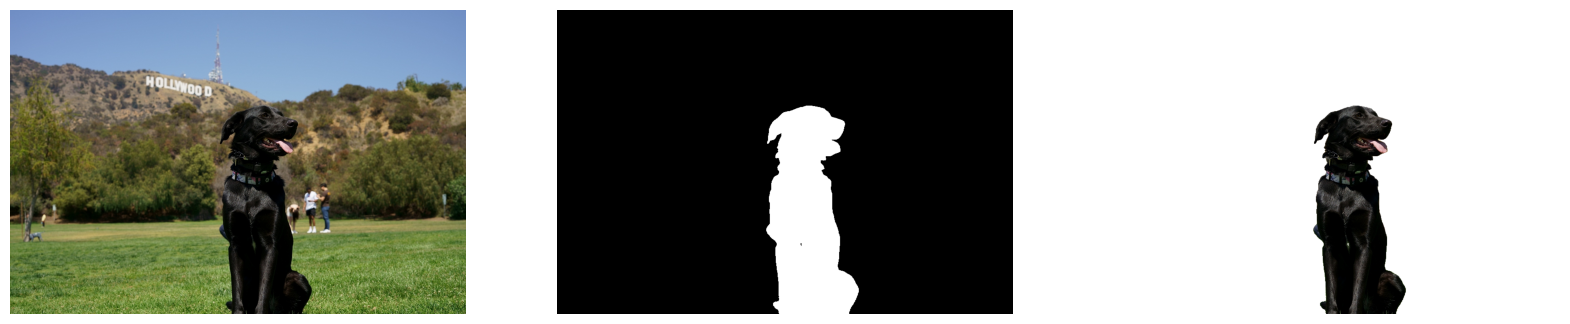

In [15]:
# Resize the network result to the image shape and round the values
# to 0 (background) and 1 (foreground).
# The network result has (1,1,512,512) shape. The `np.squeeze` function converts this to (512, 512).
resized_result = np.rint(
    cv2.resize(src=np.squeeze(result), dsize=(image.shape[1], image.shape[0]))
).astype(np.uint8)

# Create a copy of the image and set all background values to 255 (white).
bg_removed_result = image.copy()
bg_removed_result[resized_result == 0] = 255

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 7))
ax[0].imshow(image)
ax[1].imshow(resized_result, cmap="gray")
ax[2].imshow(bg_removed_result)
for a in ax:
    a.axis("off")

### 배경 이미지 추가 [$\Uparrow$](#목차:)

분할 결과에서 모든 전경 픽셀의 값은 1이고 모든 배경 픽셀의 값은 0입니다. 배경 이미지를 다음과 같이 바꿉니다.

- 새로운 '배경 이미지'를 로드합니다.
- 원본 이미지와 동일한 크기로 이미지 크기를 조정합니다.
- '배경_이미지'에서 크기가 조정된 분할 결과의 값이 1인 모든 픽셀(원본 이미지의 전경 픽셀)을 0으로 설정합니다.
- 이전 단계의 'bg_removed_result'(전경 픽셀만 포함하는 원본 이미지 부분)를 '배경 이미지'에 추가합니다.

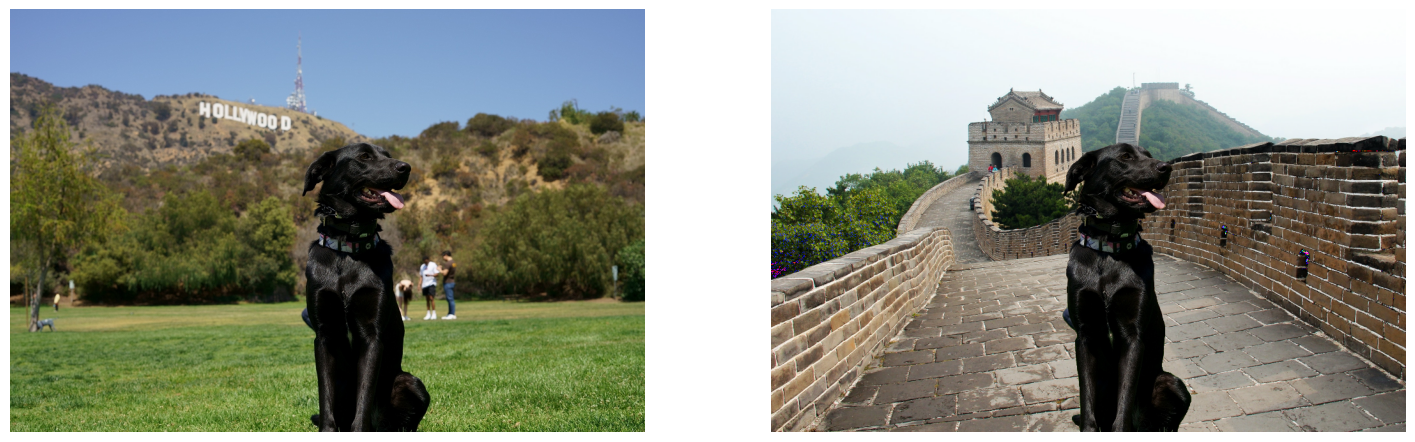

In [16]:
BACKGROUND_FILE = "https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/image/wall.jpg"
OUTPUT_DIR = "output"

os.makedirs(name=OUTPUT_DIR, exist_ok=True)

background_image = cv2.cvtColor(src=load_image("wall.jpg",BACKGROUND_FILE), code=cv2.COLOR_BGR2RGB)
background_image = cv2.resize(src=background_image, dsize=(image.shape[1], image.shape[0]))

# Set all the foreground pixels from the result to 0
# in the background image and add the image with the background removed.
background_image[resized_result == 1] = 0
new_image = background_image + bg_removed_result

# Save the generated image.
new_image_path = Path(f"{OUTPUT_DIR}/{Path(IMAGE_URI).stem}-{Path(BACKGROUND_FILE).stem}.jpg")
cv2.imwrite(filename=str(new_image_path), img=cv2.cvtColor(new_image, cv2.COLOR_RGB2BGR))

# Display the original image and the image with the new background side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 7))
ax[0].imshow(image)
ax[1].imshow(new_image)
for a in ax:
    a.axis("off")
plt.show()

# Create a link to download the image.
image_link = FileLink(new_image_path)
image_link.html_link_str = "<a href='%s' download>%s</a>"
display(
    HTML(
        f"The generated image <code>{new_image_path.name}</code> is saved in "
        f"the directory <code>{new_image_path.parent}</code>. You can also "
        "download the image by clicking on this link: "
        f"{image_link._repr_html_()}"
    )
)

## 참고문헌 [$\Uparrow$](#목차:)

* [PIP 설치 openvino-dev](https://github.com/openvinotoolkit/openvino/blob/releases/2021/3/docs/install_guides/pypi-openvino-dev.md)
* [모델 변환 API](https://docs.openvino.ai/2023.0/openvino_docs_model_processing_introduction.html)
* [U^2-Net](https://github.com/xuebinqin/U-2-Net)
* U^2-Net 연구 논문: [U^2-Net: 핵심 개체 감지를 위한 중첩된 U-구조를 통한 심층 분석](https://arxiv.org/pdf/2005.09007.pdf)